In [1]:
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes torch spacy hdbscan umap-learn scikit-learn
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 12.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
# =========================
# 1. Imports and Setup
# =========================

import os
import pandas as pd
import numpy as np
import json
import re, string
import unicodedata
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import torch
from sklearn.cluster import KMeans

from llama_index.core import Settings, Document, StorageContext, VectorStoreIndex, load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy

from sentence_transformers import SentenceTransformer     # or use TF-IDF if you prefer
# Dimensionality reduction & clustering
import umap.umap_ as umap
import seaborn as sns
import hdbscan
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
# =========================
# 2. Configuration
# =========================

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
base_path = "/home/anton/jupyter-env/nlp-project"
os.chdir(base_path)

# print pwd
print("Current working directory:", os.getcwd())

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tqdm.pandas()

model_name_embed = "sentence-transformers/all-MiniLM-L6-v2"
model_name_llm = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
chunk_size = 200
persist_dir = "storage2"

# Switch: Use vector DB or not
USE_VECTOR_DB = True  # Set to False to run agent without vector DB

Device: cuda
Current working directory: /home/anton/jupyter-env/nlp-project


[nltk_data] Downloading package punkt to /home/anton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# =========================
# 3. Data Loading & Filtering
# =========================

metadata_path = "metadata.csv"
metadata = pd.read_csv(metadata_path, dtype=str)

smoking_keywords = [
    "smoking", "smoker", "smoke", "ecigarett", "cigarett", "tobacco", "cigarette", "nicotine",
    "vaping", "vape", "e-cigarette", "cigar", "weed", "marijuana"
]
covid_terms = ["covid", "sars-cov-2", "coronavirus"]

columns_to_keep = ['cord_uid', 'title', 'abstract', 'publish_time', 'source_x', 'authors', 'pdf_json_files']
metadata = metadata[columns_to_keep]

metadata['combined_text'] = (
    metadata['title'].fillna('') + '. ' +
    metadata['abstract'].fillna('') + '. '
)

In [9]:
# remove rows with NaN in 'abstract' or 'title', pdf_json_files
metadata = metadata.dropna(subset=['abstract', 'title', 'pdf_json_files'])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326684 entries, 0 to 1056659
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   cord_uid        326684 non-null  object
 1   title           326684 non-null  object
 2   abstract        326684 non-null  object
 3   publish_time    326684 non-null  object
 4   source_x        326684 non-null  object
 5   authors         325854 non-null  object
 6   pdf_json_files  326684 non-null  object
 7   pmc_json_files  263444 non-null  object
 8   combined_text   326684 non-null  object
dtypes: object(9)
memory usage: 24.9+ MB


In [ ]:
# =========================
# 5. Read external papers. {name: text, name: text, ...}
# =========================

external_papers_path = "extracted_texts.json"
if os.path.exists(external_papers_path):
    with open(external_papers_path, 'r') as f:
        external_papers = json.load(f)
else:
    external_papers = {}


new_rows = []
for name, text in external_papers.items():
    new_rows.append({
        'cord_uid': name,
        'title': name,
        'full_text': text
    })

# Convert to DataFrame with the same columns as metadata
new_df = pd.DataFrame(new_rows)


# Add any missing columns from metadata with None values
for col in metadata.columns:
    if col not in new_df.columns:
        new_df[col] = None

# Concatenate the DataFrames
extended_papers = pd.concat([metadata, new_df], ignore_index=True)

punct_table = str.maketrans("", "", string.punctuation)
def clean_text(text):
    if not isinstance(text, str):
        return text
    text = unicodedata.normalize("NFKC", text)
    text = text.encode("utf-8", "ignore").decode("utf-8", "ignore")
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"\$.*?\$", " ", text)
    text = re.sub(r"\[\d+\]|\(\d+\)", " ", text)
    text = re.sub(r"[^\x20-\x7E]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower().strip()
    text = text.translate(punct_table)
    return text

extended_papers['combined_text'] = extended_papers['combined_text'].apply(clean_text)
extended_papers['full_text'] = extended_papers['full_text'].apply(clean_text)

# print last 5 rows of the extended_papers DataFrame
print(extended_papers.tail())

                              cord_uid                           title  \
326766       NDIGOC092507_2020_004.pdf       NDIGOC092507_2020_004.pdf   
326767          s41598-021-98749-4.pdf          s41598-021-98749-4.pdf   
326768  2020.06.01.20118877v2.full.pdf  2020.06.01.20118877v2.full.pdf   
326769          s42003-021-02685-y.pdf          s42003-021-02685-y.pdf   
326770                      VGJCUN.pdf                      VGJCUN.pdf   

       abstract publish_time source_x authors pdf_json_files pmc_json_files  \
326766     None         None     None    None           None           None   
326767     None         None     None    None           None           None   
326768     None         None     None    None           None           None   
326769     None         None     None    None           None           None   
326770     None         None     None    None           None           None   

       combined_text                                          full_text  
326766

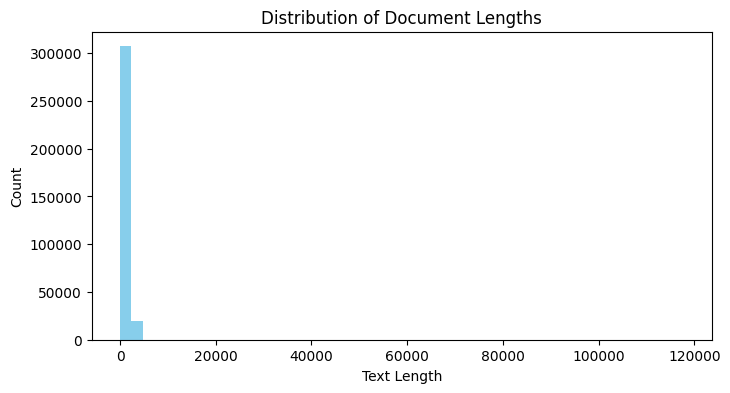

In [ ]:
# --- Outlier Detection (Text Length) ---
plt.figure(figsize=(8, 4))
plt.hist(extended_papers['combined_text'].str.len(), bins=50, color='skyblue')
plt.title("Distribution of Document Lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

In [ ]:
# How many uniques characters in the combined_text?
unique_chars = set(''.join(extended_papers['combined_text'].dropna()))
sorted_unique_chars = sorted(unique_chars)
print(f"Number of unique characters in combined_text: {len(sorted_unique_chars)}")
print("Unique characters in combined_text:", sorted_unique_chars)

Number of unique characters in combined_text: 37
Unique characters in combined_text: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
# count in each row character and wors, create new columns
extended_papers['text_length'] = extended_papers['combined_text'].str.len()
extended_papers['word_count'] = extended_papers['combined_text'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
# print statustics of the text_length and word_count columns
print("Text Length Statistics:")
print(extended_papers['text_length'].describe())
print("Word Count Statistics:")
print(extended_papers['word_count'].describe())

Text Length Statistics:
count    326684.000000
mean       1519.434245
std         650.442320
min          16.000000
25%        1150.000000
50%        1508.000000
75%        1839.000000
max      117762.000000
Name: text_length, dtype: float64
Word Count Statistics:
count    326771.000000
mean        225.212455
std          98.155800
min           0.000000
25%         168.000000
50%         222.000000
75%         272.000000
max       18038.000000
Name: word_count, dtype: float64


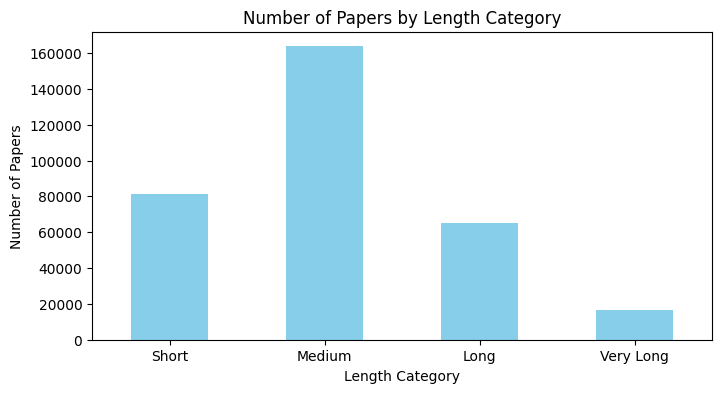

In [57]:
# Create a diagram of the text length and word count grouped by statistics under 25%, between 25% and 75%, above 75%, and very long above 95%
q25 = extended_papers['text_length'].quantile(0.25)
q75 = extended_papers['text_length'].quantile(0.75)
q95 = extended_papers['text_length'].quantile(0.95)

def categorize_length(row):
    if row['text_length'] > q95:
        return 'Very Long'
    elif row['text_length'] > q75:
        return 'Long'
    elif row['text_length'] < q25:
        return 'Short'
    else:
        return 'Medium'

extended_papers['length_category'] = extended_papers.apply(categorize_length, axis=1)
# Count the number of papers in each category
length_counts = extended_papers['length_category'].value_counts().reindex(['Short', 'Medium', 'Long', 'Very Long'])
# Plot the counts
plt.figure(figsize=(8, 4))
length_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Papers by Length Category")
plt.xlabel("Length Category")
plt.ylabel("Number of Papers")
plt.xticks(rotation=0)
plt.show()

In [58]:
extended_papers = extended_papers[
    (extended_papers['text_length'] > 100) & (extended_papers['text_length'] < 10000)
]
extended_papers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 326400 entries, 0 to 326683
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   cord_uid         326400 non-null  object 
 1   title            326400 non-null  object 
 2   abstract         326400 non-null  object 
 3   publish_time     326400 non-null  object 
 4   source_x         326400 non-null  object 
 5   authors          325584 non-null  object 
 6   pdf_json_files   326400 non-null  object 
 7   pmc_json_files   263239 non-null  object 
 8   combined_text    326400 non-null  object 
 9   full_text        0 non-null       object 
 10  text_length      326400 non-null  float64
 11  word_count       326400 non-null  int64  
 12  length_category  326400 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 34.9+ MB


In [ ]:
# export to CSV
extended_papers.to_csv("basic_filtered_papers.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch

# Copy dataset
df = extended_papers.copy()

# Load model and move to CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Create topic embeddings with tqdm
smoking_topic = " ".join(smoking_keywords)
covid_topic = " ".join(covid_terms)

print("Encoding topic embeddings...")
topic_embeddings = model.encode(
    [smoking_topic, covid_topic],
    convert_to_tensor=True,
    show_progress_bar=True,
    device=device
)

# Encode article embeddings with tqdm
print("Encoding article embeddings...")
article_embeddings = model.encode(
    list(tqdm(df['combined_text'], desc="Encoding Articles")),
    convert_to_tensor=True,
    show_progress_bar=False,
    device=device
)

# Compute cosine similarity using PyTorch (faster on GPU)
print("Calculating similarities...")
similarities = torch.nn.functional.cosine_similarity(
    article_embeddings.unsqueeze(1),  # shape: [N, 1, D]
    topic_embeddings.unsqueeze(0),    # shape: [1, 2, D]
    dim=-1
).cpu().numpy()

# Add similarity scores to DataFrame
df['smoking_similarity'] = similarities[:, 0]
df['covid_similarity'] = similarities[:, 1]

# Categorization
threshold = 0.3
def categorize_article(row):
    smoking = row['smoking_similarity'] > threshold
    covid = row['covid_similarity'] > threshold
    if smoking and covid:
        return "Both"
    elif smoking:
        return "Smoking"
    elif covid:
        return "COVID"
    else:
        return "Other"

df['category'] = df.apply(categorize_article, axis=1)



Encoding topic embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Encoding article embeddings...


Encoding Articles: 100%|███████████████████████████████████████████████████| 326400/326400 [00:00<00:00, 2536929.13it/s]


Calculating similarities...


In [ ]:
# save the DataFrame with similarity scores and categories
df = df[['cord_uid', 'title', 'abstract', 'publish_time', 'authors', 'pdf_json_files', 'smoking_similarity', 'covid_similarity', 'category']]
df.to_csv("articles_with_similarity_and_categories.csv", index=False)